In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing, neighbors, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
  RandomForestRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score,  confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

import itertools
from itertools import cycle

import pickle
DIR_DATA = "data"
DIR_PROCESSED = "processed"
LABEL = "Status"
NON_PREDICTORS = [LABEL]#, "name","anime_id"]
CV_FOLDS = 5

In [2]:
# No-show-Issue-Comma-300k.csv

In [3]:
ma = pd.read_csv(DIR_DATA + '/No-show-Issue-Comma-300k.csv')
ma.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [4]:
print('Percent who left: {:.2f}%'.format((1 - np.sum(ma.Status == 'Show-Up') / len(ma.Status)) * 100))

Percent who left: 30.24%


In [5]:
def getTime(appointment):
    hour, minute, _ = appointment.strip('Z').split(':')
    
    hour = int(hour[-2:])
    minute = int(minute)
    return 60*hour + minute

ma["AppointmenTime"] = ma.AppointmentRegistration.apply(lambda x: getTime(x))

In [6]:
ma.describe()

,Age,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AppointmenTime
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,37.808017,0.077967,0.025010,0.215890,0.020523,0.052370,0.096897,0.000450,0.574173,-13.841813,705.811503
std,22.809014,0.268120,0.156156,0.411439,0.155934,0.222772,0.295818,0.021208,0.499826,15.687697,193.880593
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-398.000000,354.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20.000000,537.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-8.000000,667.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.000000,872.000000
max,113.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,-1.000000,1362.000000


In [7]:
ma.Status = ma.Status.astype('category').cat.codes
ma.Gender = ma.Gender.astype('category').cat.codes
ma.DayOfTheWeek = ma.DayOfTheWeek.astype('category').cat.codes
# hr.Work_accident = hr.Work_accident.astype('category')
# hr.promotion_last_5years = hr.promotion_last_5years.astype('category')
# hr.left = hr.left.astype('category')

# Normalizing waiting time to mean 0 and unit variance
ma.AwaitingTime = ma.AwaitingTime.astype(np.float64)
wait_time_scaler = preprocessing.MinMaxScaler() #preprocessing.StandardScaler()
ma.AwaitingTime = wait_time_scaler.fit_transform(ma.AwaitingTime.values.reshape(-1,1))

# Feature Scaling Age to be between [0,1]
ma.Age = ma.Age.astype(np.float64)
age_scaler = preprocessing.MinMaxScaler()
ma.Age = age_scaler.fit_transform(ma.Age.values.reshape(-1,1))

# Feature Scaling Age to be between [0,1]
ma.AppointmenTime = ma.AppointmenTime.astype(np.float64)
time_scaler = preprocessing.MinMaxScaler()
ma.AppointmenTime = time_scaler.fit_transform(ma.AppointmenTime.values.reshape(-1,1))




In [8]:
ma.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AppointmenTime
0,0.182609,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,6,1,0,0,0,0,0,0,0,0,0.929471,0.527778
1,0.226087,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,6,1,0,0,0,0,0,0,0,0,1.000000,0.066468
2,0.052174,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,5,1,0,0,0,0,0,0,0,0,1.000000,0.415675
3,0.060870,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,4,1,0,0,0,0,0,0,0,1,0.964736,0.662698
4,0.347826,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,5,1,0,0,0,0,0,0,0,1,0.987406,0.561508


In [9]:
ma.describe()

,Age,Gender,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AppointmenTime
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.346157,0.331650,3.326650,0.697563,0.077967,0.025010,0.215890,0.020523,0.052370,0.096897,0.000450,0.574173,0.967653,0.349019
std,0.198339,0.470807,2.283518,0.459314,0.268120,0.156156,0.411439,0.155934,0.222772,0.295818,0.021208,0.499826,0.039516,0.192342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.182609,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.952141,0.181548
50%,0.347826,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.982368,0.310516
75%,0.504348,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.992443,0.513889
max,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000


In [ ]:
drop = ['Status','AppointmentRegistration','ApointmentData']
def predict_left(df, clf, test_size=0.2):
    X = df.drop(drop,1)
    y = df.Status 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    print('Training Score: {:.3f}'.format(clf.score(X_train, y_train)))
    print('Testing Score: %.3f' % (clf.score(X_test, y_test)))
    
    print()

In [ ]:
predict_left(ma, svm.SVC())

In [83]:
# Random Forest is bad at this, and K-NN is good but slow
classifiers = [ LogisticRegression(), AdaBoostClassifier(),xgb.XGBClassifier(nthread=-1), MultinomialNB()]#, neighbors.KNeighborsClassifier(n_jobs=-1)] #svm.SVC(), GradientBoostingClassifier(),  neighbors.KNeighborsClassifier(n_jobs=-1)], RandomForestClassifier(n_jobs=-1), RandomForestClassifier(criterion='entropy', n_jobs=-1),
# classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1), xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    predict_left(ma, clf)

Classifier  0
Training Score: 0.697
Testing Score: 0.697

Classifier  1
Training Score: 0.697
Testing Score: 0.699

Classifier  2
Training Score: 0.698
Testing Score: 0.699

Classifier  3
Training Score: 0.697
Testing Score: 0.700



In [14]:
def cross_val_left(df, clf, cv_folds=CV_FOLDS, drop=drop):
    X = df.drop(drop, 1)#, 'sales', 'salary'],1)
    y = df.Status 
    scores = cross_val_score(clf, X, y, cv=cv_folds, n_jobs=-1)
    
    
    
    print('Cross val score: ', sum(scores) / cv_folds )
    print(scores)
    
    print()
    

In [55]:
classifiers = [xgb.XGBClassifier(n_estimators=500, nthread=-1), LogisticRegression(), AdaBoostClassifier(n_estimators=500), MultinomialNB()]#} RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]#, svm.SVC()]#]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(ma, clf)

Classifier  0
Cross val score:  0.697773335911
[ 0.69735504  0.69813333  0.6981      0.69715     0.6981283 ]

Classifier  1
Cross val score:  0.697186666633
[ 0.69720505  0.69723333  0.69755     0.69675     0.69719495]

Classifier  2
Cross val score:  0.698016669133
[ 0.69740504  0.69816667  0.69825     0.69811667  0.69814497]

Classifier  3
Cross val score:  0.697576667244
[ 0.69732171  0.69761667  0.69785     0.6976      0.69749496]



In [21]:
clf = xgb.XGBClassifier(n_estimators=500, nthread=-1)
X = ma.drop(drop,1)
y = ma.Status 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(X.columns)
clf.feature_importances_
# Drop all lower than 0.01 relevance

Index(['Age', 'Gender', 'DayOfTheWeek', 'Diabetes', 'Alcoolism',
       'HiperTension', 'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis',
       'Sms_Reminder', 'AwaitingTime'],
      dtype='object')


array([ 0.33168775,  0.02992903,  0.08546745,  0.01542734,  0.01481024,
        0.01758716,  0.04072817,  0.01758716,  0.01727862,  0.0046282 ,
        0.05399568,  0.37087318], dtype=float32)

In [23]:
# Dropping all with <0.01 relevance seems to not affect score much (.9920->.9916)
drop = ['left', 'promotion_last_5years', 'Work_accident', 'sales', 'salary']
for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

In [56]:
ma.corr()["Status"]

Age               0.099814
Gender           -0.011546
DayOfTheWeek      0.019352
Status            1.000000
Diabetes          0.031073
Alcoolism        -0.025459
HiperTension      0.059053
Handcap           0.006613
Smokes           -0.024055
Scholarship      -0.041030
Tuberculosis     -0.003823
Sms_Reminder      0.000164
AwaitingTime      0.066790
AppointmenTime   -0.028790
Name: Status, dtype: float64

In [20]:
# Drop everything with corr to left of < 0.005
# Makes it worse
drop = ['left',  'sales', 'salary']
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]#, svm.SVC()]#xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.991866310918
[ 0.99833389  0.98133333  0.98666667  0.99866622  0.99433144]

Classifier  1
Cross val score:  0.991666266474
[ 0.99866711  0.981       0.986       0.99833278  0.99433144]



In [35]:
ma.columns

Index(['Age', 'Gender', 'AppointmentRegistration', 'ApointmentData',
       'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism', 'HiperTension',
       'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
       'AwaitingTime'],
      dtype='object')

In [57]:
from sklearn.feature_selection import RFE
model = xgb.XGBClassifier(n_estimators=500, nthread=-1)#RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf = RFE(model,5 )

X = ma.drop(drop,1)
y = ma.Status 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(clf.support_)
print(clf.ranking_)
# Gets same result as feature_importance, which makes sense

[ True False  True False False False False False False False  True  True
  True]
[1 3 1 7 6 5 2 8 4 9 1 1 1]


In [58]:
# from sklearn.feature_selection import RFE
model = LogisticRegression()
clf = RFE(model,5 )

X = ma.drop(drop,1)
y = ma.Status 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(clf.support_)
print(clf.ranking_)
# Gets same result as feature_importance

[ True False False False  True False False  True False False False  True
  True]
[1 9 8 6 1 5 7 1 2 3 4 1 1]


In [59]:
# PCA on relevant features
# drop = ['left',  'sales', 'salary']

y = np.array(ma.Status)

X = np.array(ma.drop(drop,1))
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

In [60]:
print(pca.components_)

[[  1.42543185e-04   6.34551710e-04  -9.99974299e-01   3.58192477e-04
    3.10766391e-04   4.41535707e-04  -1.13743339e-04   2.58151421e-04
    1.59869246e-04   1.14964135e-05   7.08346651e-03  -3.73062762e-04
   -3.73305533e-04]
 [ -5.14356713e-02  -1.87878101e-01   6.63230228e-03  -6.51214400e-02
   -1.65047835e-02  -1.52563258e-01  -1.41486401e-02  -1.67049001e-02
    3.72909682e-02  -3.31822157e-04   9.65208099e-01  -1.86683239e-02
   -1.94499798e-02]]


In [61]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[ 0.84226544  0.04093448]
0.883199917187


In [62]:
# Still get good same accuracy, ~69.7%
clf = xgb.XGBClassifier(n_estimators=500, nthread=-1)
y = np.array(ma.Status) 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.697500000466
[ 0.69747171  0.69741667  0.69741667  0.69758333  0.69761163]


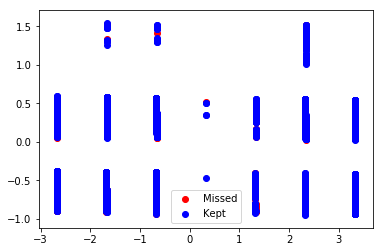

In [63]:
colors = cycle('rb')
target_ids = range(2)
plt.figure()
for i, c, label in zip(target_ids, colors, ["Missed","Kept"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                c=c, label=label)
plt.legend()
plt.show()

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


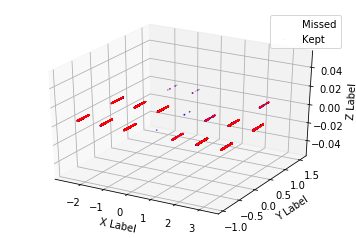

In [23]:
# 3D PCA, Clear plane difference between them
# drop = ['left',  'sales', 'salary']

y = np.array(ma.Status)

X = np.array(ma.drop(drop,1))
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

colors = cycle('rb')
target_ids = range(2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, c, label in zip(target_ids, colors, ["Missed", "Kept"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],X_pca[y == i, 2],
                c=c, label=label)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
    
plt.legend()
plt.show()

In [65]:
# 3D accuracy is the same as 2D
clf = xgb.XGBClassifier(n_estimators=500, nthread=-1)
y = ma.Status 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.697423334022
[ 0.69737171  0.6974      0.6974      0.69736667  0.69757829]


In [26]:
clf = svm.SVC()#LogisticRegression(n_jobs=-1, C=0.1)
X = ma.drop(drop,1)
y = ma.Status 
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
print(classification_report(y_test,y_pred, target_names=class_names))

             precision    recall  f1-score   support

    No-Show       0.00      0.00      0.00     18125
    Show-Up       0.70      1.00      0.82     41875

avg / total       0.49      0.70      0.57     60000



/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


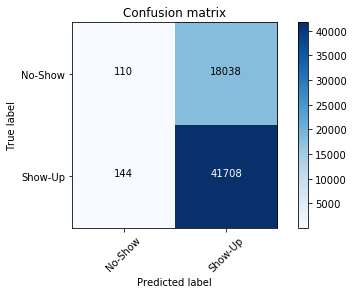

In [12]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=10)

class_names = ["No-Show","Show-Up"]

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()

In [105]:
print(classification_report(y_test,y_pred, target_names=class_names))

             precision    recall  f1-score   support

    No-Show       0.00      0.00      0.00     18040
    Show-Up       0.70      1.00      0.82     41960

avg / total       0.49      0.70      0.58     60000



/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
